In [171]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as ssn
from sklearn.impute import KNNImputer
import numpy as np

In [172]:
#Exploracion de datos
sales = pd.read_csv(r'C:\Users\REPO\Tec2025\HackForHer\Dataset _ Coolers AC\sales.csv')
warnings = pd.read_csv(r'C:\Users\REPO\Tec2025\HackForHer\Dataset _ Coolers AC\warnings.csv')
coolers = pd.read_csv(r'C:\Users\REPO\Tec2025\HackForHer\Dataset _ Coolers AC\coolers.csv')


In [211]:
# Asegúrate de que calday sea string para separar
coolers_fecha = coolers.copy()
coolers_fecha['calday'] = coolers_fecha['calday'].astype(str)

# Crear nuevas columnas
coolers_fecha['year'] = coolers_fecha['calday'].str[:4]
coolers_fecha['month'] = coolers_fecha['calday'].str[4:6]
coolers_fecha['day'] = coolers_fecha['calday'].str[6:8]

# Si prefieres que sean enteros:
coolers_fecha[['year', 'month', 'day']] = coolers_fecha[['year', 'month', 'day']].astype(int)


In [212]:
coolers_fecha.to_csv('coolers_fecha.csv', header=True)

In [174]:
#Se asigna columna de si presenta warning = 1 || no presenta = 0
coolers_warnings = coolers
coolers_warnings['warning'] = coolers['cooler_id'].isin(warnings['cooler_id']).astype(int)

In [175]:
# Media por grupo
media = coolers.groupby('warning').mean(numeric_only=True)

# Mediana por grupo
mediana = coolers.groupby('warning').median(numeric_only=True)

# Moda por grupo (puede devolver varias filas si hay empates)
moda = coolers.groupby('warning').agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)


In [176]:
media

,door_opens,open_time,compressor,power,on_time,min_voltage,max_voltage,temperature,calday
warning,,,,,,,,,
0,564.689189,226.897665,125.033273,102.652713,20.877456,110.778271,127.202884,5.147108,2.024504e+07
1,48.364843,6.243284,49.895094,138.098412,22.539604,107.556559,126.163569,6.067482,2.023822e+07


<Axes: title={'center': 'door_opens'}, xlabel='warning'>

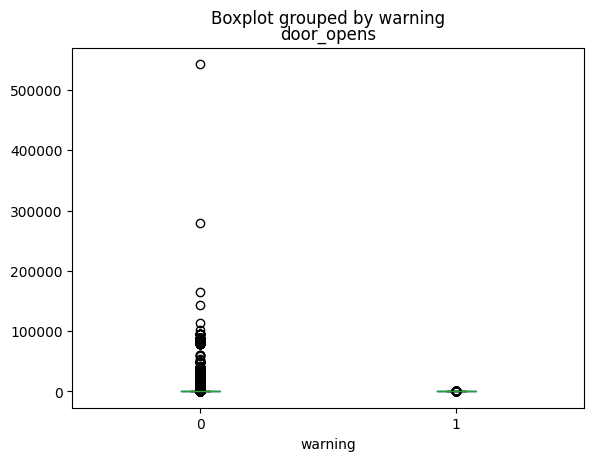

In [177]:
#visualizacion de datos
coolers_warnings.boxplot(column='door_opens', by='warning', grid=False)

<Axes: title={'center': 'power'}, xlabel='warning'>

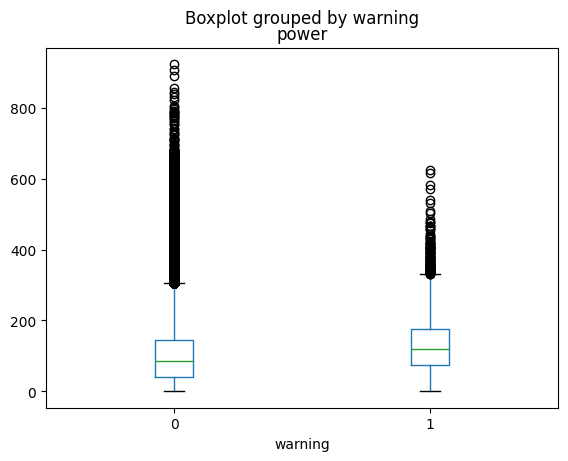

In [178]:
coolers_warnings.boxplot(column='power', by='warning', grid=False)

<Axes: title={'center': 'min_voltage'}, xlabel='warning'>

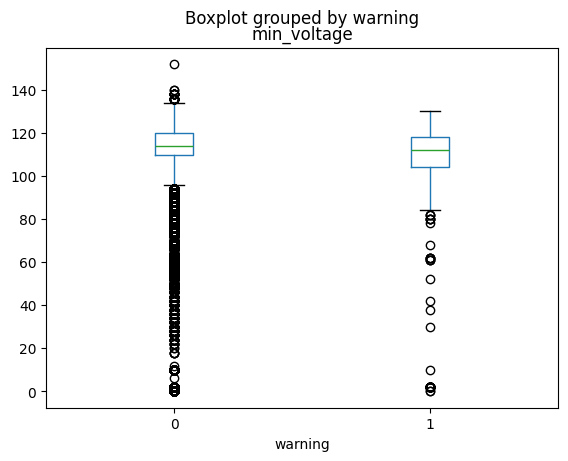

In [179]:
coolers_warnings.boxplot(column='min_voltage', by='warning', grid=False)

<Axes: title={'center': 'max_voltage'}, xlabel='warning'>

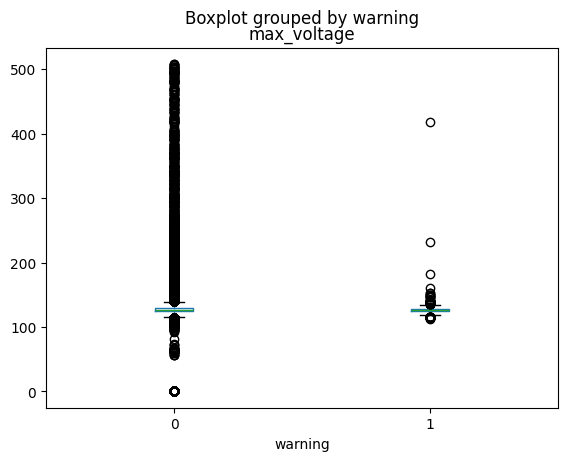

In [180]:
coolers_warnings.boxplot(column='max_voltage', by='warning', grid=False)

In [181]:
#SUBSET DE LOS QUE NO TIENEN FALLAS PARA MAPEAR DISTRIBUCION
# Paso 1: seleccionar 53 cooler_id únicos donde warning == 0
coolers_sin_warning = coolers[coolers['warning'] == 0]
cooler_ids_sample = coolers_sin_warning['cooler_id'].drop_duplicates().sample(n=53, random_state=42)

# Paso 2: seleccionar todas las filas con esos cooler_id
subset_sinwarnings = coolers[coolers['cooler_id'].isin(cooler_ids_sample)].copy()

subset_nowarning_completo = coolers[coolers['warning'] == 0].copy()

#CON WARNINGS
subset_warnings = coolers[coolers['warning'] == 1].copy()

In [182]:
subset_warnings['cooler_id'].head()

3487    8c23cc35a965e01affe215db22e5be71b86189f4d6f9c0...
3488    8c23cc35a965e01affe215db22e5be71b86189f4d6f9c0...
3489    8c23cc35a965e01affe215db22e5be71b86189f4d6f9c0...
3490    8c23cc35a965e01affe215db22e5be71b86189f4d6f9c0...
3491    8c23cc35a965e01affe215db22e5be71b86189f4d6f9c0...
Name: cooler_id, dtype: object

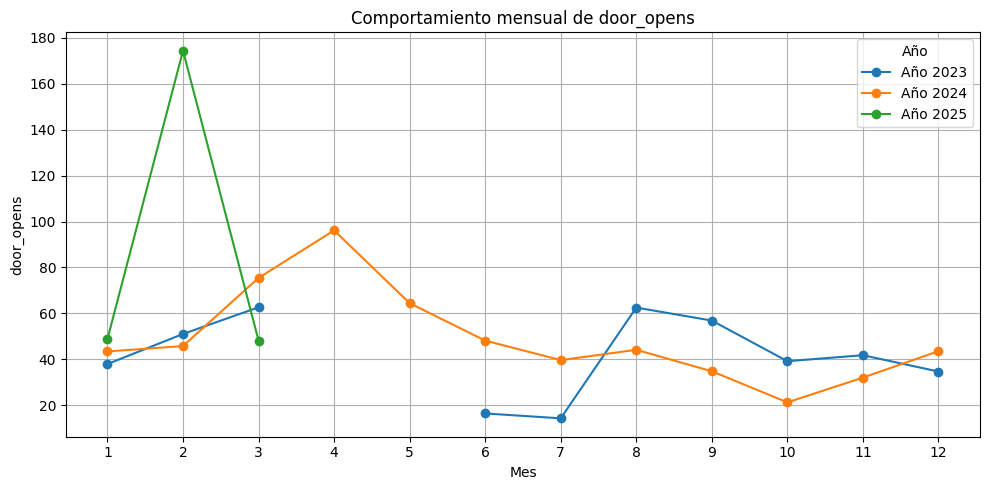

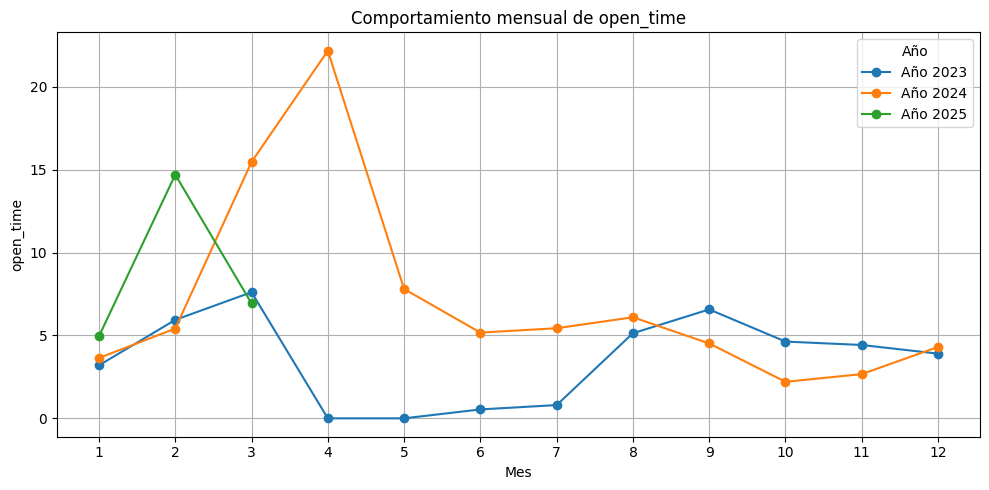

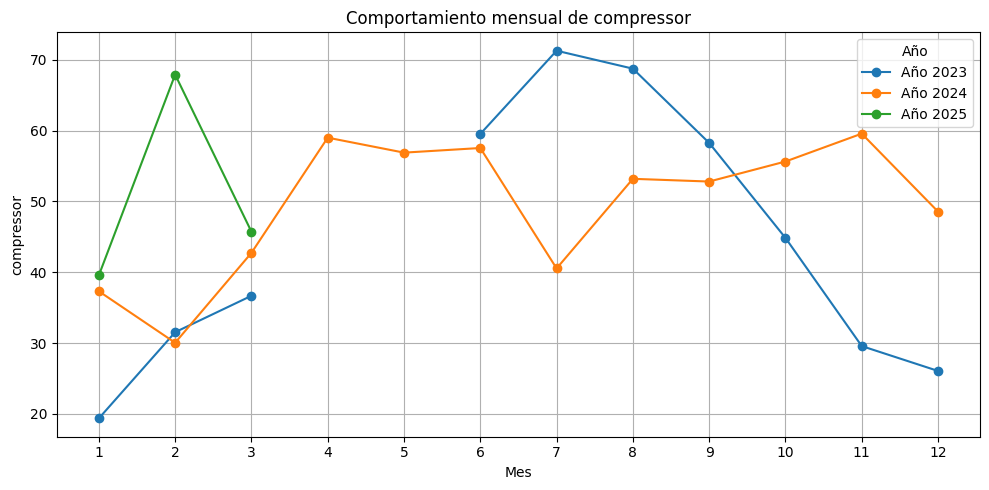

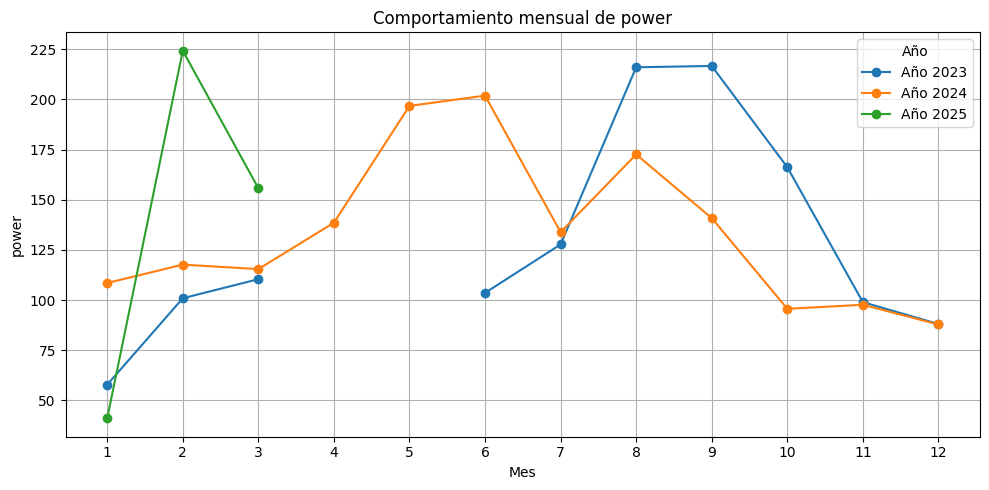

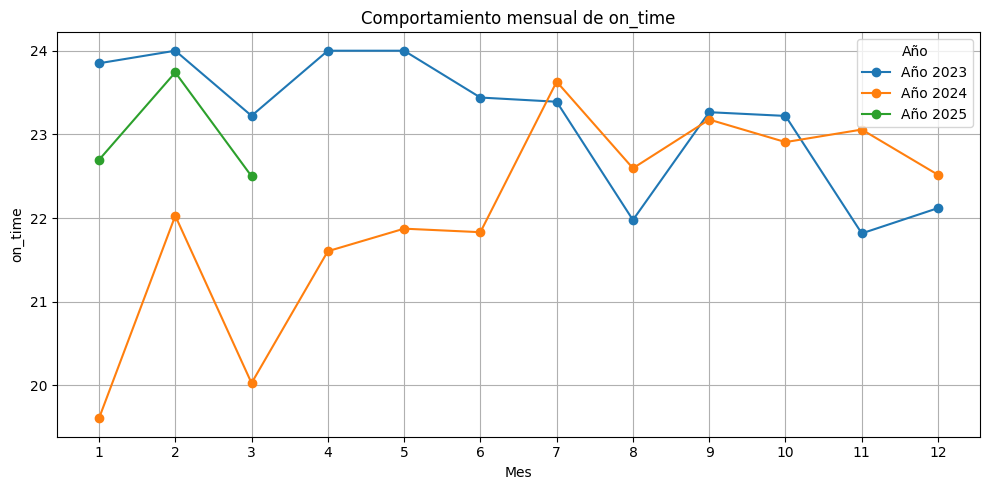

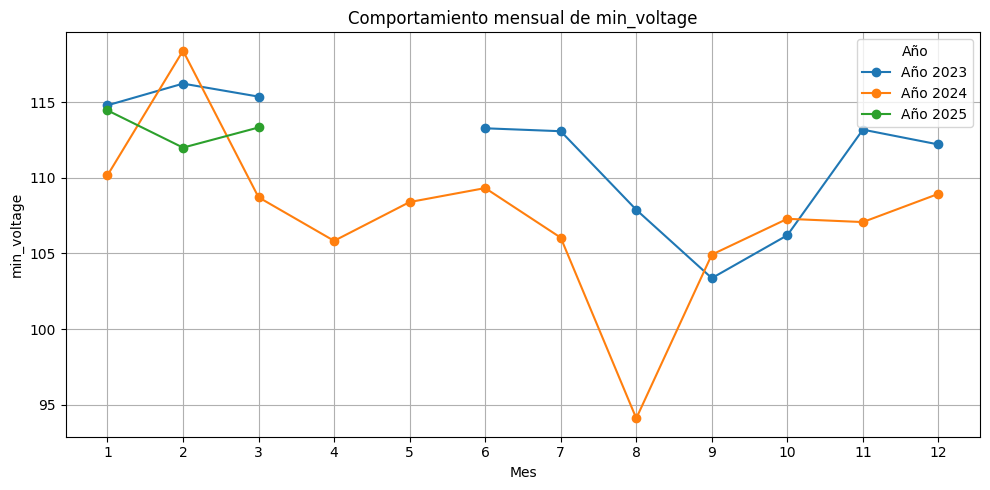

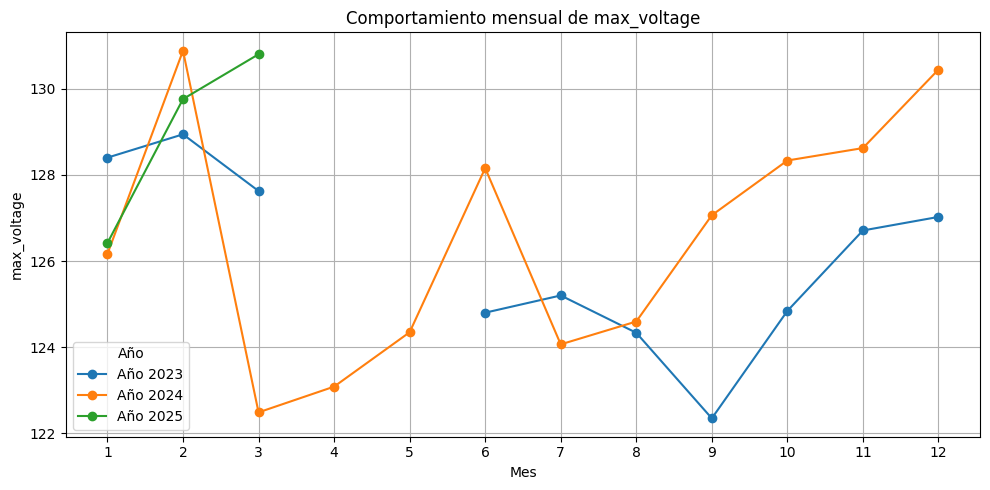

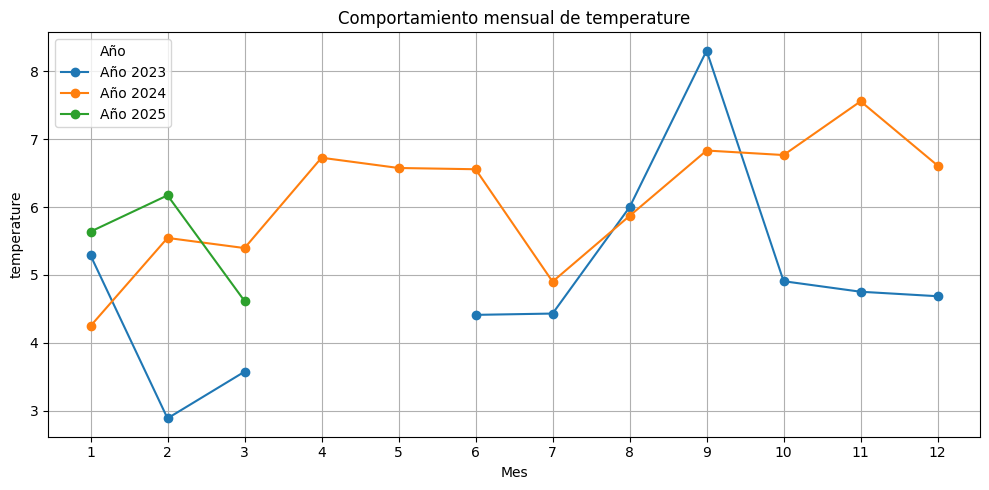

In [183]:
import matplotlib.pyplot as plt
features =  ['door_opens', 'open_time',	'compressor',	'power',	'on_time',	'min_voltage',	'max_voltage',	'temperature']  
# Convertir calday a datetime
subset_warnings['calday'] = pd.to_datetime(subset_warnings['calday'].astype(str), format='%Y%m%d')

# Extraer año y mes
subset_warnings['year'] = subset_warnings['calday'].dt.year
subset_warnings['month'] = subset_warnings['calday'].dt.month

# Agrupar por año y mes, calcular la media
monthly_means = subset_warnings.groupby(['year', 'month'])[features].mean().reset_index()

# Graficar cada variable por separado
for feature in features:
    plt.figure(figsize=(10, 5))
    
    for year in sorted(monthly_means['year'].unique()):
        subset = monthly_means[monthly_means['year'] == year]
        plt.plot(subset['month'], subset[feature], marker='o', label=f'Año {year}')
    
    plt.title(f'Comportamiento mensual de {feature}')
    plt.xlabel('Mes')
    plt.ylabel(feature)
    plt.xticks(range(1, 13))
    plt.legend(title='Año')
    plt.grid(True)
    plt.tight_layout()
    plt.show()



In [184]:
# PLOTEA DATOS POR COOLER ID
def plot_cooler_features_by_month(df, cooler_id):
    """
    Genera gráficas por mes y año para cada feature de un cooler específico.

    :param df: DataFrame con los datos
    :param cooler_id: ID del cooler a analizar
    """
    # Filtrar por cooler_id
    df_cooler = df[df['cooler_id'] == cooler_id].copy()
    
    if df_cooler.empty:
        print(f"No se encontraron datos para cooler_id: {cooler_id}")
        return
    
    # Convertir calday a datetime manejando formatos mixtos
    df_cooler['calday'] = pd.to_datetime(df_cooler['calday'], errors='coerce', infer_datetime_format=True)
    
    # Verifica si hay fechas no convertidas
    if df_cooler['calday'].isnull().any():
        print("Advertencia: algunas fechas no se pudieron convertir y se omitirán.")
        df_cooler = df_cooler.dropna(subset=['calday'])
    
    # Extraer año y mes
    df_cooler['year'] = df_cooler['calday'].dt.year
    df_cooler['month'] = df_cooler['calday'].dt.month
    
    # Agrupar por año y mes
    monthly_means = df_cooler.groupby(['year', 'month']).mean(numeric_only=True).reset_index()
    
    # Lista de features a graficar
    features = ['door_opens', 'open_time', 'compressor', 'power', 
                'on_time', 'min_voltage', 'max_voltage', 'temperature']
    
    # Graficar cada feature
    for feature in features:
        plt.figure(figsize=(10, 5))
        
        for year in sorted(monthly_means['year'].unique()):
            subset = monthly_means[monthly_means['year'] == year]
            plt.plot(subset['month'], subset[feature], marker='o', label=f'Año {year}')
        
        plt.title(f'Comportamiento mensual de {feature} (Cooler {cooler_id})')
        plt.xlabel('Mes')
        plt.ylabel(feature)
        plt.xticks(range(1, 13))
        plt.legend()
        plt.grid(True)
        plt.show()

C:\Users\Maria Paula\AppData\Local\Temp\ipykernel_26460\2527337475.py:17: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_cooler['calday'] = pd.to_datetime(df_cooler['calday'], errors='coerce', infer_datetime_format=True)


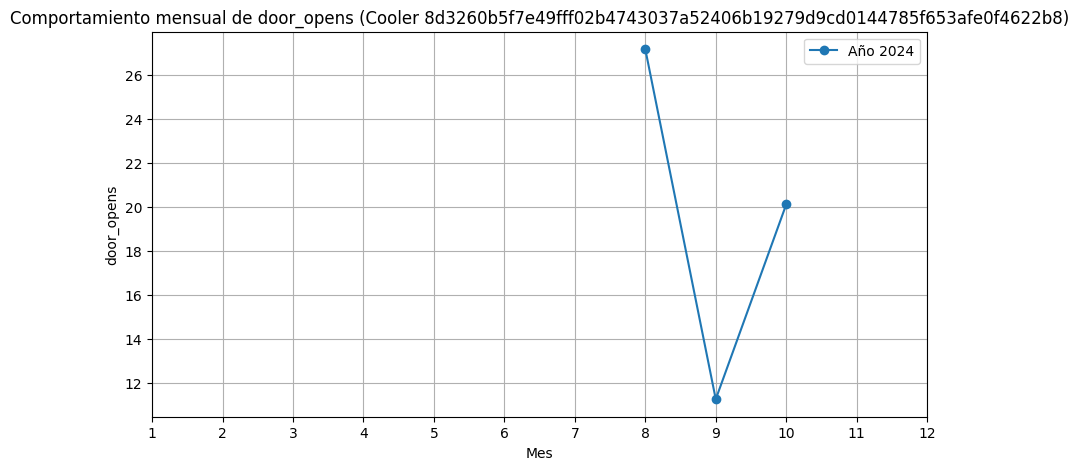

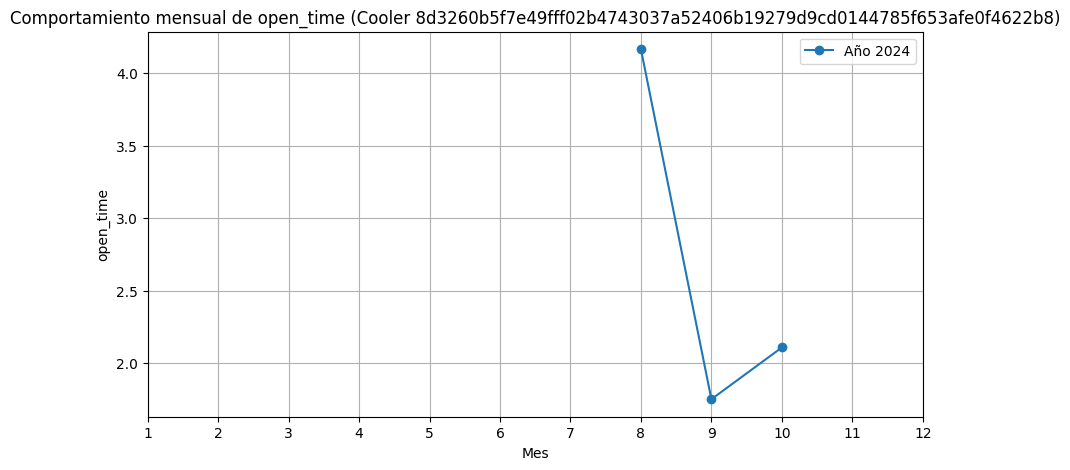

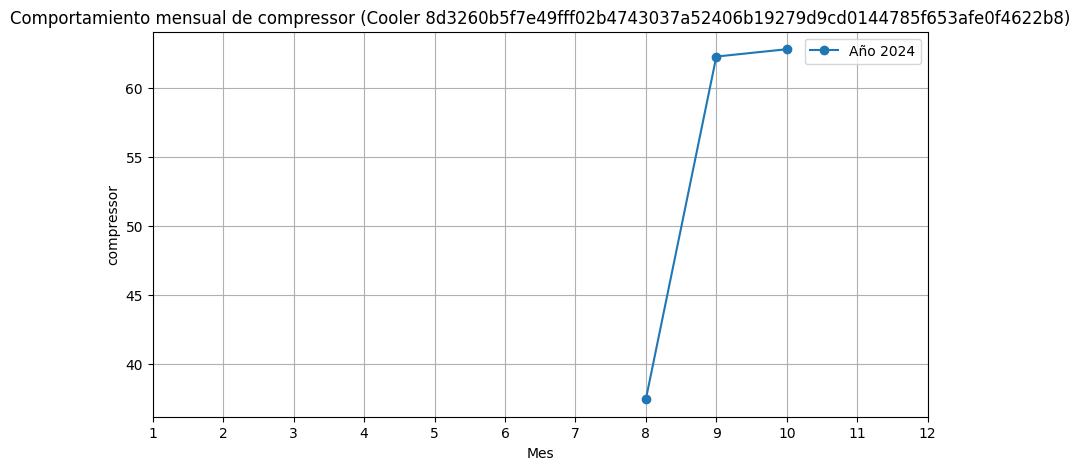

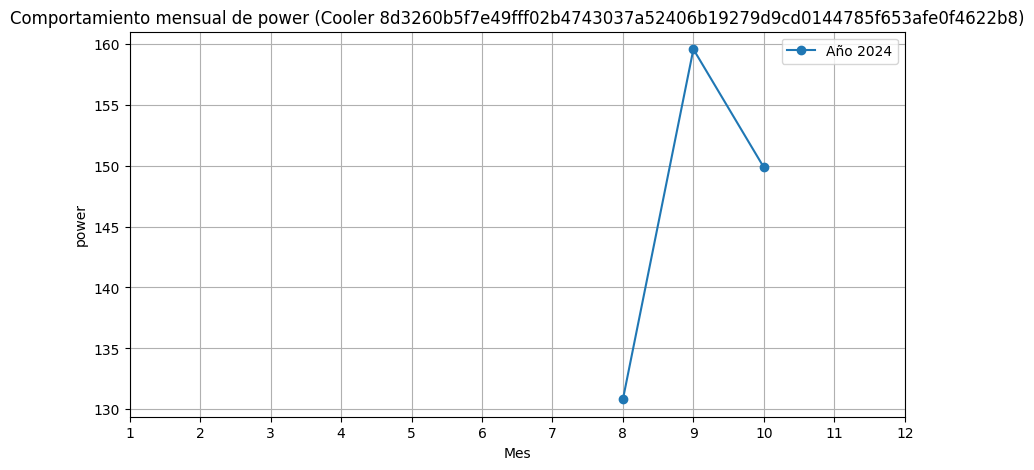

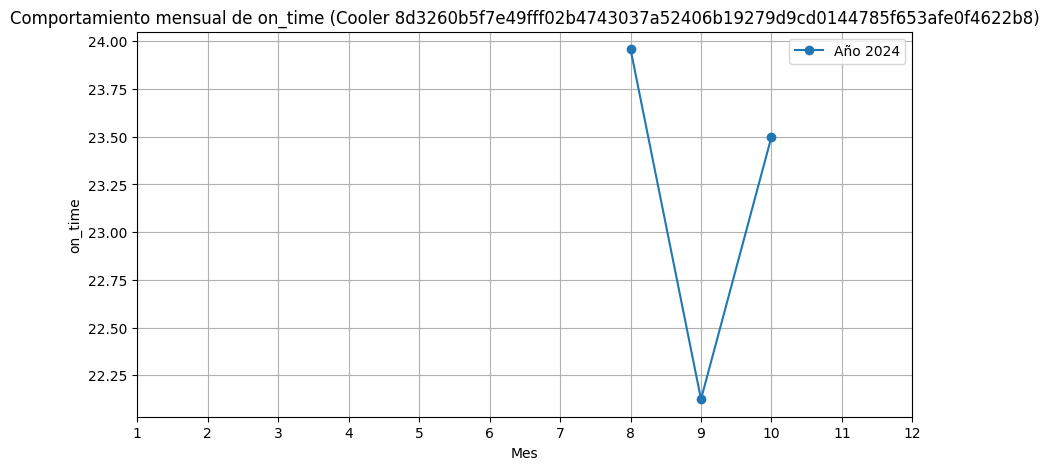

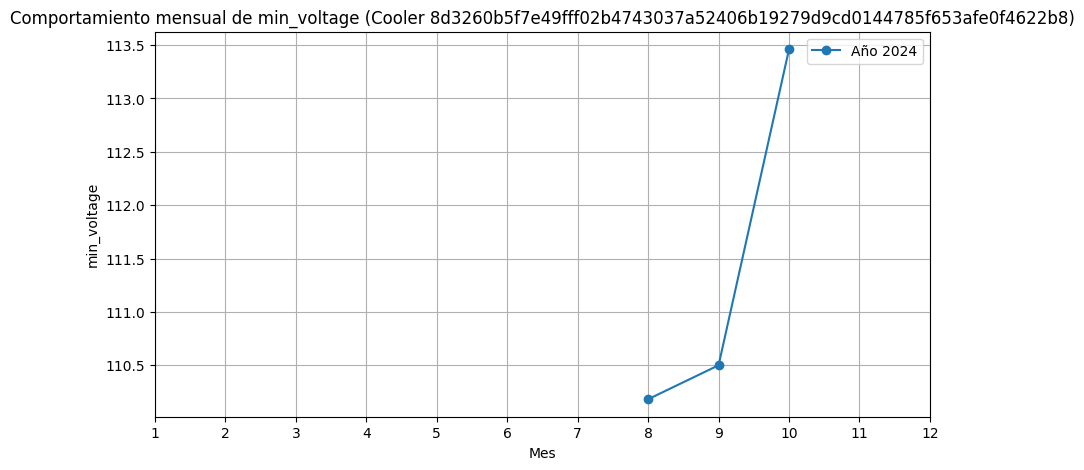

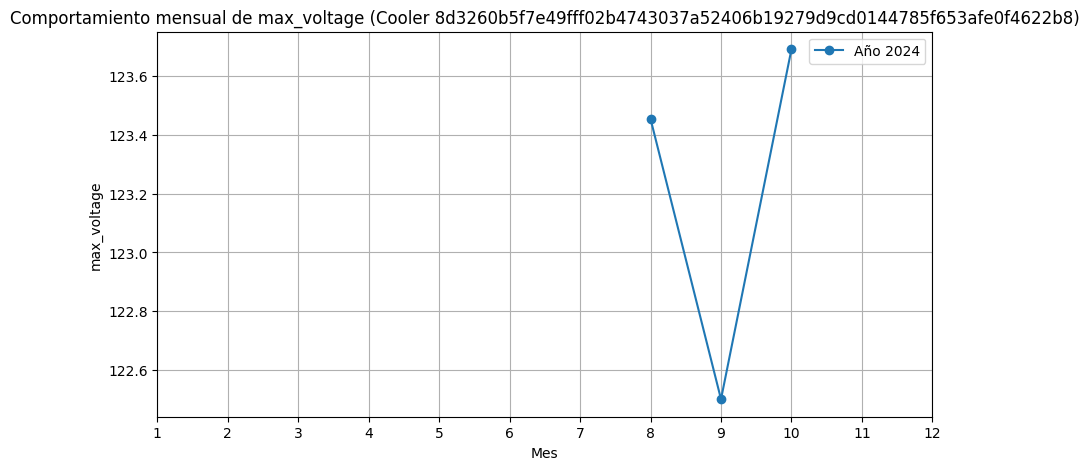

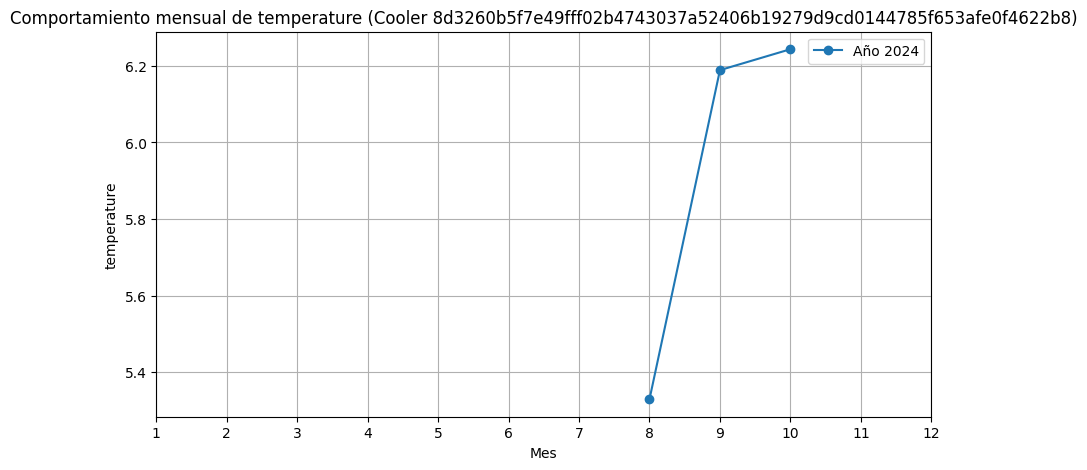

In [185]:
plot_cooler_features_by_month(subset_warnings, '8d3260b5f7e49fff02b4743037a52406b19279d9cd0144785f653afe0f4622b8')

In [186]:
#WARNING POR DIA
def plot_cooler_features_by_day(df, cooler_id):
    """
    Genera gráficas por día del mes y año para cada feature de un cooler específico.

    :param df: DataFrame con los datos
    :param cooler_id: ID del cooler a analizar
    """
    # Filtrar por cooler_id
    df_cooler = df[df['cooler_id'] == cooler_id].copy()
    
    if df_cooler.empty:
        print(f"No se encontraron datos para cooler_id: {cooler_id}")
        return
    
    
    # Verifica si hay fechas no convertidas
    if df_cooler['calday'].isnull().any():
        print("Advertencia: algunas fechas no se pudieron convertir y se omitirán.")
        df_cooler = df_cooler.dropna(subset=['calday'])
    
    # Extraer año, mes y día
    df_cooler['year'] = df_cooler['calday'].dt.year
    df_cooler['month'] = df_cooler['calday'].dt.month
    df_cooler['day'] = df_cooler['calday'].dt.day
    
    # Agrupar por año, mes y día
    daily_means = df_cooler.groupby(['year', 'month', 'day']).mean(numeric_only=True).reset_index()
    
    # Lista de features a graficar
    features = ['door_opens', 'open_time', 'compressor', 'power', 
                'on_time', 'min_voltage', 'max_voltage', 'temperature']
    
    # Graficar cada feature
    for feature in features:
        plt.figure(figsize=(12, 6))
        
        # Graficar para cada año y mes
        for (year, month), group in daily_means.groupby(['year', 'month']):
            plt.plot(group['day'], group[feature], marker='o', label=f'{year}-{month:02d}')
        
        plt.title(f'Comportamiento diario de {feature} (Cooler {cooler_id})')
        plt.xlabel('Día del mes')
        plt.ylabel(feature)
        plt.xticks(range(1, 32))
        plt.legend(title='Año-Mes')
        plt.grid(True)
        plt.show()

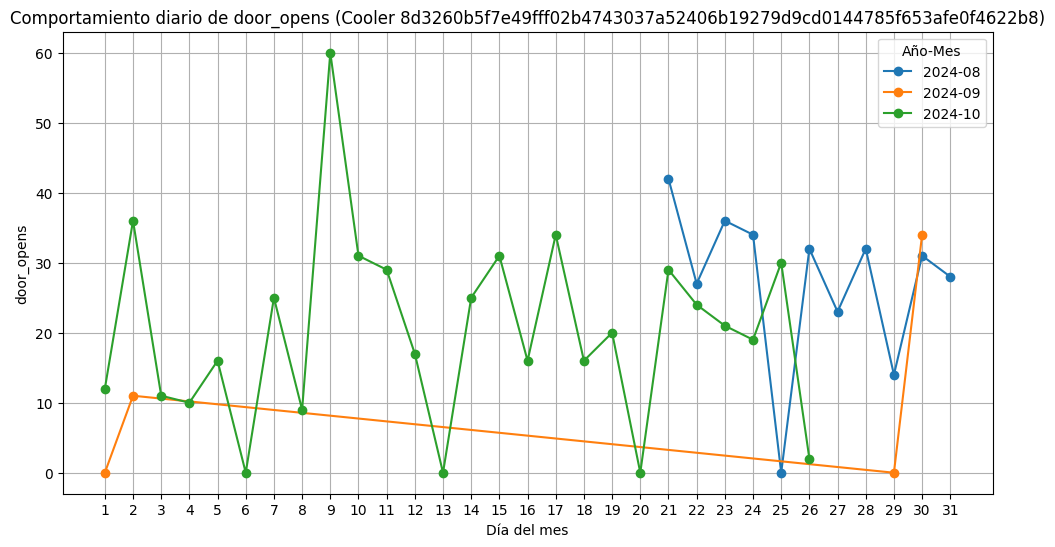

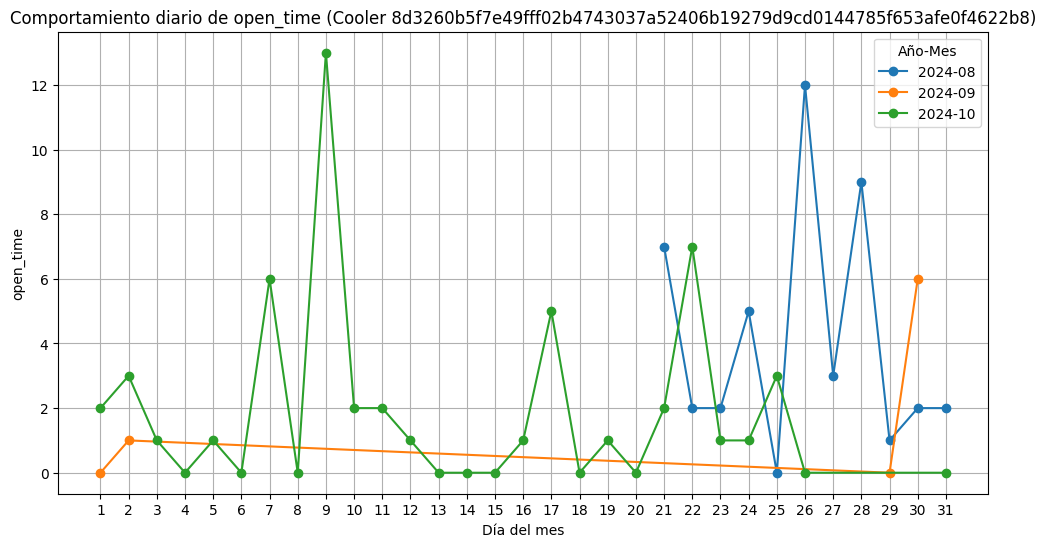

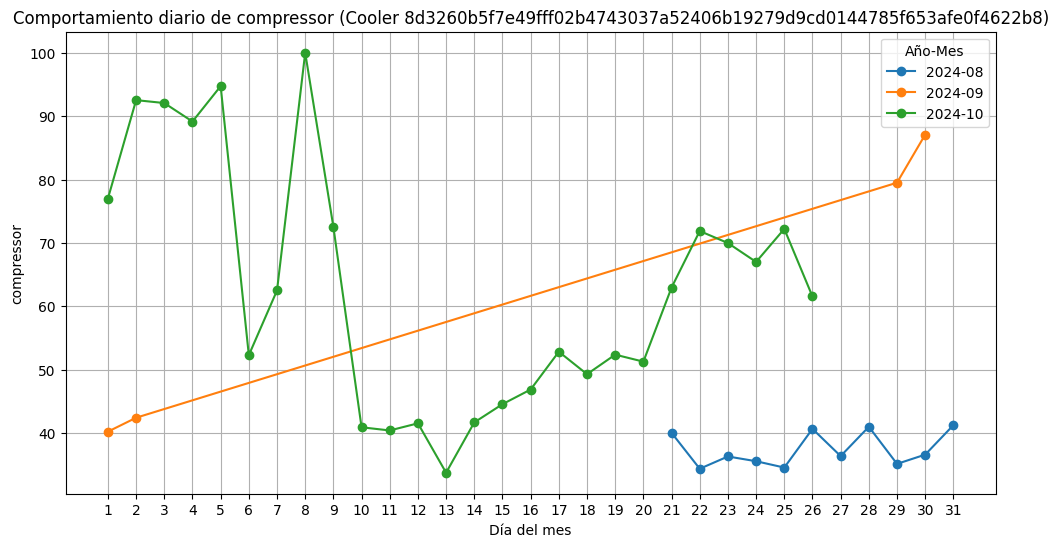

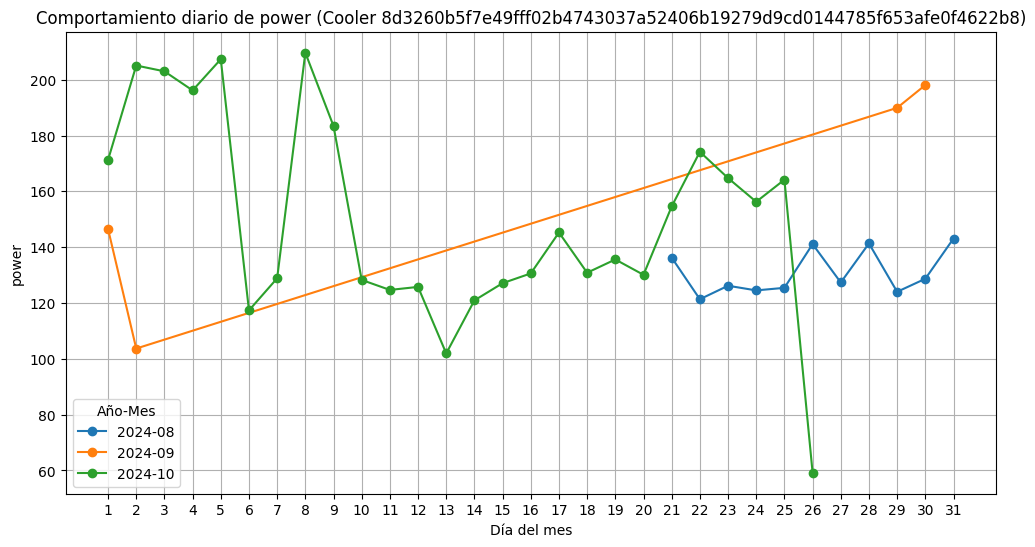

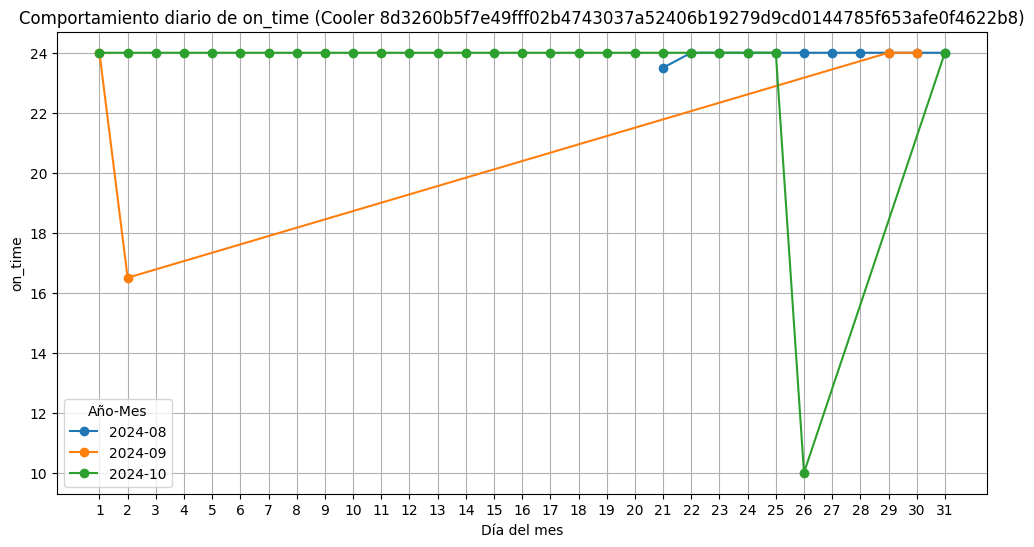

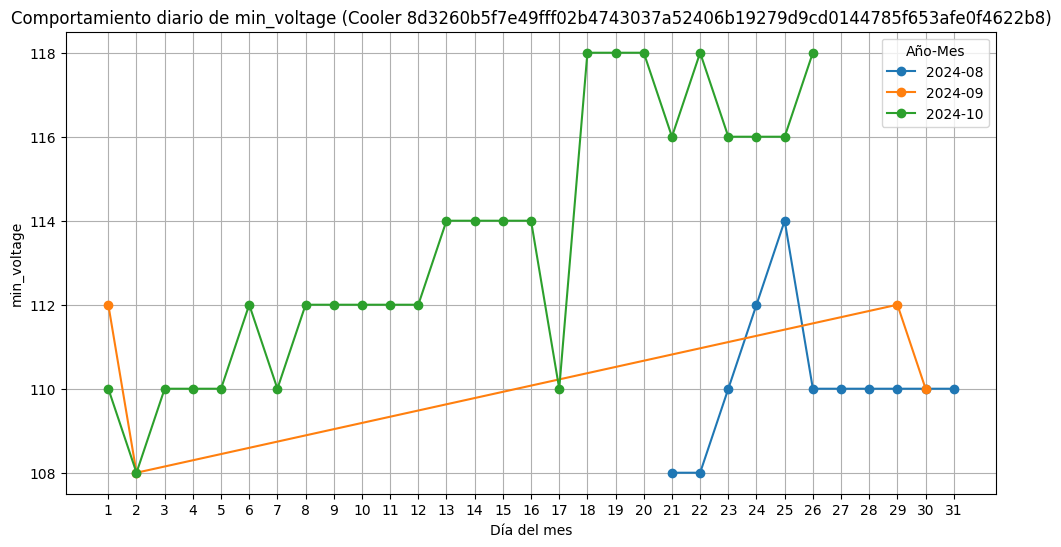

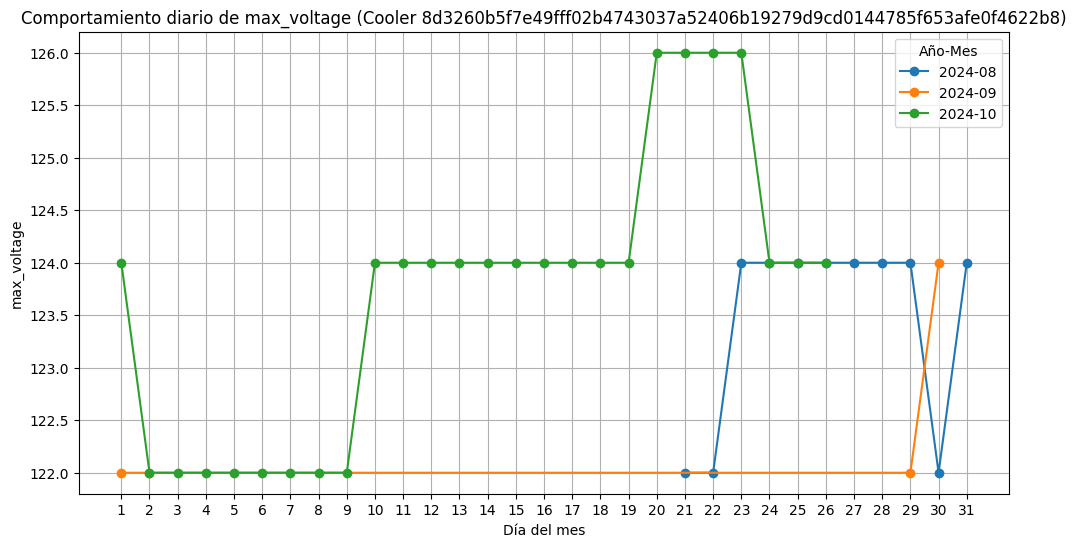

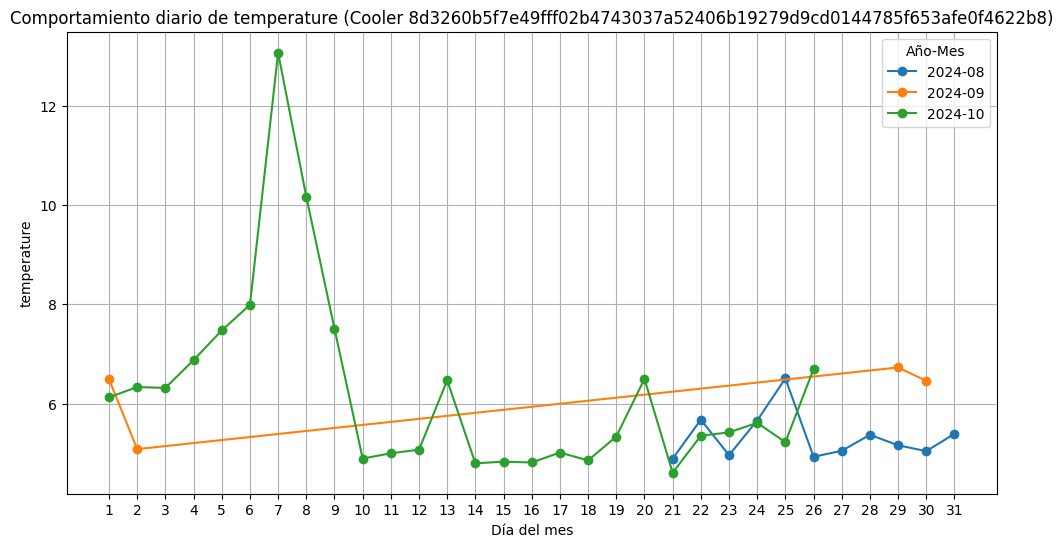

In [187]:
plot_cooler_features_by_day(subset_warnings, '8d3260b5f7e49fff02b4743037a52406b19279d9cd0144785f653afe0f4622b8')

In [188]:
    # Asegúrate de que calday esté en datetime
subset_warnings['calday'] = pd.to_datetime(subset_warnings['calday'])

    # Extrae año y mes
subset_warnings['year'] = subset_warnings['calday'].dt.year
subset_warnings['month'] = subset_warnings['calday'].dt.month

    # Crear un DataFrame con todos los meses esperados por cooler_id y año
cooler_periods = subset_warnings[['cooler_id', 'year']].drop_duplicates()

    # Expandir con todos los meses
cooler_periods = cooler_periods.assign(key=1).merge(
        pd.DataFrame({'month': range(1, 13), 'key': 1}),
        on='key'
    ).drop('key', axis=1)

    # Obtener combinaciones realmente presentes en los datos
present_months = subset_warnings[['cooler_id', 'year', 'month']].drop_duplicates()

    # Detectar combinaciones que faltan
missing_months = pd.merge(
        cooler_periods, 
        present_months, 
        on=['cooler_id', 'year', 'month'], 
        how='left', 
        indicator=True
    ).query('_merge == "left_only"').drop('_merge', axis=1)

missing_months.head(10)  # Muestra las primeras 10 filas


,cooler_id,year,month
0,8c23cc35a965e01affe215db22e5be71b86189f4d6f9c0...,2024,1
1,8c23cc35a965e01affe215db22e5be71b86189f4d6f9c0...,2024,2
2,8c23cc35a965e01affe215db22e5be71b86189f4d6f9c0...,2024,3
3,8c23cc35a965e01affe215db22e5be71b86189f4d6f9c0...,2024,4
6,8c23cc35a965e01affe215db22e5be71b86189f4d6f9c0...,2024,7
7,8c23cc35a965e01affe215db22e5be71b86189f4d6f9c0...,2024,8
8,8c23cc35a965e01affe215db22e5be71b86189f4d6f9c0...,2024,9
9,8c23cc35a965e01affe215db22e5be71b86189f4d6f9c0...,2024,10
10,8c23cc35a965e01affe215db22e5be71b86189f4d6f9c0...,2024,11
11,8c23cc35a965e01affe215db22e5be71b86189f4d6f9c0...,2024,12


In [189]:
missing_months_filtrado = missing_months[missing_months['year'] != 2025]

faltantes_por_cooler = missing_months_filtrado.groupby('cooler_id').size().reset_index(name='meses_faltantes')
faltantes_por_cooler = faltantes_por_cooler.sort_values(by='meses_faltantes', ascending=False)
faltantes_por_cooler

,cooler_id,meses_faltantes
7,35d532dc23d4b4fb12a571c630c3b159514fb86f61e5c6...,21
14,4904fb0a5242543cc1568baac25a6f977cc910a1260175...,20
10,452761b13d1a97635372b33e09ea2a8008a486fe79a360...,20
9,3d320be49b4ed88a8a2ecd893934c1b77d713429d9098c...,20
4,12ef32f2133e68b37554f01de6a72e38c1fa1985585a71...,20
16,5005dc421283c3024eeedd99caa4ec7e8a067cc2986792...,20
48,e56d7ffa46dc9b6558fc8cbf6ac3e16a24575a2d7ba833...,20
50,e6d7afe0ba9cb0b12859414261f96e0b65080805af5525...,20
35,98b412465c6b6b8f1971fb107bd205b0693eff901a63be...,20
29,872cdd275f9f091ec2178959775ee929d25020e920d1ba...,20


In [190]:
'''# imputacion de datos con KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
scaler = StandardScaler()
sinwarnings_scaled = scaler.fit_transform(subset_sinwarnings[features])
conwarnings_scaled = scaler.fit_transform(subset_warnings[features])

def imputador(df, variables):
    """
    Imputa valores faltantes en columnas numéricas usando KNN,
    preservando columnas no imputadas como 'cooler_id'.

    Parámetros:
    - df: DataFrame original
    - variables: lista de columnas numéricas a imputar

    Retorna:
    - DataFrame con las columnas imputadas y las demás columnas intactas.
    """
    # Copia del DataFrame
    df_copy = df.copy()

    # Asegurar que todas las variables están presentes
    missing = [v for v in variables if v not in df_copy.columns]
    if missing:
        raise ValueError(f"Faltan columnas en el DataFrame: {missing}")

    # Aplicar imputación solo a las variables indicadas
    imputer = KNNImputer(n_neighbors=3)
    X_imputed = imputer.fit_transform(df_copy[variables])

    # Reasignar los valores imputados
    df_copy[variables] = X_imputed

    return df_copy

# Reconstruye DataFrame a partir del array y columnas
sinwarnings_scaled_df = pd.DataFrame(sinwarnings_scaled, columns=features)
# Ahora aplica tu función
sinwarnings_imputed = imputador(sinwarnings_scaled_df, features)'''

'# imputacion de datos con KNNImputer\nfrom sklearn.preprocessing import StandardScaler\nfrom sklearn.impute import KNNImputer\nscaler = StandardScaler()\nsinwarnings_scaled = scaler.fit_transform(subset_sinwarnings[features])\nconwarnings_scaled = scaler.fit_transform(subset_warnings[features])\n\ndef imputador(df, variables):\n    """\n    Imputa valores faltantes en columnas numéricas usando KNN,\n    preservando columnas no imputadas como \'cooler_id\'.\n\n    Parámetros:\n    - df: DataFrame original\n    - variables: lista de columnas numéricas a imputar\n\n    Retorna:\n    - DataFrame con las columnas imputadas y las demás columnas intactas.\n    """\n    # Copia del DataFrame\n    df_copy = df.copy()\n\n    # Asegurar que todas las variables están presentes\n    missing = [v for v in variables if v not in df_copy.columns]\n    if missing:\n        raise ValueError(f"Faltan columnas en el DataFrame: {missing}")\n\n    # Aplicar imputación solo a las variables indicadas\n    imp

In [191]:
def generar_target_por_columna(df, base_col, k, cooler_col='cooler_id', date_col='calday',
                                window=30, threshold='iqr', target_col='Target'):

    df = df.sort_values([cooler_col, date_col]).copy()

    # Detectar umbral atípico
    if threshold == 'iqr':
        Q1 = df[base_col].quantile(0.25)
        Q3 = df[base_col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - k * IQR
        upper_bound = Q3 + k * IQR
    elif isinstance(threshold, (int, float)):
        lower_bound = -np.inf
        upper_bound = threshold
    else:
        raise ValueError("threshold debe ser 'iqr' o un número")

    # Marcar días con valor atípico
    df['anomalía'] = ((df[base_col] < lower_bound) | (df[base_col] > upper_bound)).astype(int)

    # Inicializar columna de target
    df[target_col] = 0

    # Expandir anomalías hacia los días anteriores
    for cooler in df[cooler_col].unique():
        idx = df[df[cooler_col] == cooler].index
        flags = df.loc[idx, 'anomalía'].values

        target_flags = np.zeros(len(flags), dtype=int)
        for i in range(len(flags)):
            if flags[i] == 1:
                start = max(0, i - window)
                target_flags[start:i+1] = 1  # incluye el día actual y días anteriores
        df.loc[idx, target_col] = target_flags

    df.drop(columns=['anomalía'], inplace=True)
    return df


In [192]:
subset_warnings.columns

Index(['cooler_id', 'door_opens', 'open_time', 'compressor', 'power',
       'on_time', 'min_voltage', 'max_voltage', 'temperature', 'calday',
       'warning', 'year', 'month'],
      dtype='object')

# GENERAR TARGET METRIC

In [193]:
def generar_target_por_anomalia(df, base_cols, cooler_col='cooler_id', date_col='calday',
                                  window=30, target_col='Target'):
    """
    Marca como 1 el target si ambas columnas base tienen valor 0 en un día dado,
    y propaga ese target a los siguientes 'window' días para cada cooler.
    
    Parámetros:
        df: DataFrame de entrada.
        base_cols: Lista con los nombres de las dos columnas a evaluar.
        cooler_col: Columna con el ID del cooler.
        date_col: Columna con la fecha (tipo datetime).
        window: Número de días para extender el target después de una anomalía.
        target_col: Nombre de la columna de salida.
    """

    if len(base_cols) != 2:
        raise ValueError("base_cols debe contener exactamente dos nombres de columna")

    col1, col2 = base_cols

    df = df.sort_values([cooler_col, date_col]).copy()

    # Detectar días donde ambas columnas valen 0
    df['anomalía'] = ((df[col1] == 0) & (df[col2] == 0)).astype(int)

    # Inicializar columna target
    df[target_col] = 0

    # Expandir anomalías a los siguientes N días
    for cooler in df[cooler_col].unique():
        idx = df[df[cooler_col] == cooler].index
        flags = df.loc[idx, 'anomalía'].values

        target_flags = np.zeros(len(flags), dtype=int)
        for i in range(len(flags)):
            if flags[i] == 1:
                target_flags[i:i + window + 1] = 1
        df.loc[idx, target_col] = target_flags

    df.drop(columns=['anomalía'], inplace=True)
    return df


In [194]:
subset_warnings_targetpuertas = subset_warnings
subset_warnings_targetpuertas['Target'] = None
subset_warnings_targetpuertas = generar_target_por_anomalia(subset_warnings, base_cols=['door_opens', 'open_time'])

In [195]:
print(subset_warnings_targetpuertas['Target'].value_counts())


Target
0    1412
1     608
Name: count, dtype: int64


In [196]:
subset_warnings_targetpuertas[subset_warnings_targetpuertas['Target'] == 1]['cooler_id'].nunique()

22

In [197]:
subset_warnings_targetpuertas['Motive'] = 'puertas_no_abren'

# Target de warning por columna

In [198]:
def generar_target_por_columna_dias_futuros(df, base_col, k, cooler_col='cooler_id', date_col='calday',
                                window=30, threshold='iqr', target_col='Target'):


    df = df.sort_values([cooler_col, date_col]).copy()

    # Detectar umbral atípico
    if threshold == 'iqr':
        Q1 = df[base_col].quantile(0.25)
        Q3 = df[base_col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - k* IQR
        upper_bound = Q3 + k* IQR
    elif isinstance(threshold, (int, float)):
        lower_bound = -np.inf
        upper_bound = threshold
    else:
        raise ValueError("threshold debe ser 'iqr' o un número")

    # Marcar días con valor atípico
    df['anomalía'] = ((df[base_col] < lower_bound) | (df[base_col] > upper_bound)).astype(int)

    # Inicializar columna de target
    df[target_col] = 0

    # Expandir anomalías a los siguientes N días
    for cooler in df[cooler_col].unique():
        idx = df[df[cooler_col] == cooler].index
        flags = df.loc[idx, 'anomalía'].values

        # Marcar los siguientes N días como 1
        target_flags = np.zeros(len(flags), dtype=int)
        for i in range(len(flags)):
            if flags[i] == 1:
                target_flags[i:i+window+1] = 1  # incluye el día actual
        df.loc[idx, target_col] = target_flags

    df.drop(columns=['anomalía'], inplace=True)
    return df


falla con compresor

In [199]:
subset_warnings_targetcompresor = generar_target_por_columna(subset_warnings, base_col='compressor',k=0.5)
subset_warnings_targetcompresor['Motive'] = 'compressor'
subset_warnings_targetcompresor[subset_warnings_targetcompresor['Target'] == 1]['cooler_id'].nunique()

29

In [200]:
compressor = subset_warnings['compressor']
Q1 = compressor.quantile(0.25)
Q3 = compressor.quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 0.5 * IQR
upper = Q3 + 0.5 * IQR
print(f"Rango permitido: {lower} a {upper}")
print(f"Valores fuera del rango: {(compressor < lower).sum()} debajo, {(compressor > upper).sum()} arriba")

Rango permitido: 11.423174999999997 a 89.317275
Valores fuera del rango: 17 debajo, 128 arriba


falla con temperatura

In [201]:
subset_warnings_targettemp = generar_target_por_columna(subset_warnings, base_col='temperature', k=1.5)
subset_warnings_targettemp['Motive'] = 'temperature'
subset_warnings_targettemp[subset_warnings_targetcompresor['Target'] == 1]['cooler_id'].nunique()

29

In [202]:
compressor = subset_warnings['temperature']
Q1 = compressor.quantile(0.25)
Q3 = compressor.quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR
print(f"Rango permitido: {lower} a {upper}")
print(f"Valores fuera del rango: {(compressor < lower).sum()} debajo, {(compressor > upper).sum()} arriba")

Rango permitido: 1.5701250000000004 a 9.571925
Valores fuera del rango: 0 debajo, 137 arriba


uniendo fallas

In [203]:
# Luego: unir el resultado con el tercero
fallas_concat = pd.concat(
    [subset_warnings_targettemp, subset_warnings_targetcompresor],
    axis=0,  # vertical
    ignore_index=True
)

In [204]:
fallas_concat.nunique()

cooler_id        53
door_opens      208
open_time        67
compressor     1602
power          1361
on_time          42
min_voltage      37
max_voltage      25
temperature    1563
calday          660
warning           1
year              3
month            12
Target            2
Motive            2
dtype: int64

In [205]:
fallas_concat.to_csv("Fallas_con_target.csv", header=True,  encoding='utf-8' )

In [206]:
subset_sinwarnings['Motive'] = 'None'
subset_sinwarnings['Target'] = 0
subset_sinwarnings.to_csv("subset_sinwarnings.csv", header=True,  encoding='utf-8')

In [207]:
subset_nowarning_completo['Motive'] = 'None'
subset_nowarning_completo['Target'] = 0
subset_nowarning_completo.to_csv("nowarning_complete.csv", header=True,  encoding='utf-8')

In [208]:
# datasets sin incluir febrero
def sin_feb(df, ruta_salida):

    # Asegurarse de que calday esté en formato datetime
    df = df.copy()
    df['calday'] = pd.to_datetime(df['calday'].astype(str), format='%Y%m%d', errors='coerce')

    # Filtrar todo excepto febrero (mes 2)
    df_sin_febrero = df[df['calday'].dt.month != 2]

    # Guardar a CSV
    df_sin_febrero.to_csv(ruta_salida, index=False)

    print(f"Archivo guardado sin registros de febrero en: {ruta_salida}")
    return df_sin_febrero

sin_feb(fallas_concat, "fallas_sin_feb.csv")
sin_feb(subset_sinwarnings, "sinwarnings_sinfeb.csv")

Archivo guardado sin registros de febrero en: fallas_sin_feb.csv
Archivo guardado sin registros de febrero en: sinwarnings_sinfeb.csv


,cooler_id,door_opens,open_time,compressor,power,on_time,min_voltage,max_voltage,temperature,calday,warning,Motive,Target
3223,3e2599f10b34afeb3cb4b3f02402c680a3a60b51411e34...,99.0,19.0,55.2500,200.3333,24.0,86.0,124.0,4.6354,2025-04-26,0,None,0
3224,3e2599f10b34afeb3cb4b3f02402c680a3a60b51411e34...,6.0,0.0,31.7708,111.8333,24.0,92.0,122.0,5.5417,2025-04-25,0,None,0
3225,3e2599f10b34afeb3cb4b3f02402c680a3a60b51411e34...,72.0,3.0,37.3469,134.5000,24.0,98.0,124.0,4.3816,2025-04-30,0,None,0
3226,3e2599f10b34afeb3cb4b3f02402c680a3a60b51411e34...,11.0,0.0,40.1714,100.9167,17.5,90.0,124.0,5.3171,2025-04-24,0,None,0
3227,3e2599f10b34afeb3cb4b3f02402c680a3a60b51411e34...,71.0,7.0,48.0208,170.4167,24.0,80.0,340.0,5.2417,2025-04-23,0,None,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
332929,858efb99e310d4bf002a287964e706ab8106bac8467a23...,2.0,0.0,19.3333,0.0000,9.0,102.0,130.0,5.8944,2024-12-28,0,None,0
332930,858efb99e310d4bf002a287964e706ab8106bac8467a23...,NaN,0.0,NaN,NaN,24.0,NaN,NaN,NaN,2024-11-06,0,None,0
332931,858efb99e310d4bf002a287964e706ab8106bac8467a23...,115.0,14.0,34.8542,0.0000,24.0,102.0,132.0,5.1583,2025-04-20,0,None,0
332932,858efb99e310d4bf002a287964e706ab8106bac8467a23...,123.0,14.0,48.6458,0.0000,24.0,98.0,132.0,3.7500,2025-04-19,0,None,0


In [209]:
# datasets SOLO  febrero
def con_feb(df, ruta_salida):

    # Asegurarse de que calday esté en formato datetime
    df = df.copy()
    df['calday'] = pd.to_datetime(df['calday'].astype(str), format='%Y%m%d', errors='coerce')

    # Filtrar todo excepto febrero (mes 2)
    df_sin_febrero = df[df['calday'].dt.month == 2]

    # Guardar a CSV
    df_sin_febrero.to_csv(ruta_salida, index=False)

    print(f"Archivo guardado sin registros de febrero en: {ruta_salida}")
    return df_sin_febrero

con_feb(fallas_concat, "fallas_feb.csv")
con_feb(subset_sinwarnings, "sinwarnings_feb.csv")

Archivo guardado sin registros de febrero en: fallas_feb.csv
Archivo guardado sin registros de febrero en: sinwarnings_feb.csv


,cooler_id,door_opens,open_time,compressor,power,on_time,min_voltage,max_voltage,temperature,calday,warning,Motive,Target
25165,b306b142c1f798a89a70ffe8fede8a55b62f36f770000a...,80.0,6.0,26.7917,0.0000,24.0,116.0,124.0,4.7146,2025-02-26,0,None,0
25166,b306b142c1f798a89a70ffe8fede8a55b62f36f770000a...,68.0,18.0,23.2708,0.0000,24.0,118.0,124.0,4.6000,2025-02-28,0,None,0
25169,b306b142c1f798a89a70ffe8fede8a55b62f36f770000a...,66.0,11.0,24.1458,0.0000,24.0,116.0,124.0,4.6771,2025-02-27,0,None,0
25170,b306b142c1f798a89a70ffe8fede8a55b62f36f770000a...,80.0,10.0,25.3958,0.0000,24.0,116.0,124.0,4.6792,2025-02-25,0,None,0
35052,d1f91bf148f121cde100224a681080e482c6ba59df0947...,NaN,0.0,NaN,NaN,24.0,NaN,NaN,NaN,2025-02-18,0,None,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
301209,a9e368fc3c702e3f5619bd8eb1226ef44cd7aa8aa06f62...,68.0,4.0,38.3750,100.8333,24.0,114.0,122.0,3.4146,2025-02-19,0,None,0
301210,a9e368fc3c702e3f5619bd8eb1226ef44cd7aa8aa06f62...,37.0,2.0,32.6042,85.1667,24.0,112.0,122.0,3.3333,2025-02-18,0,None,0
302721,0d403392049e5902d6324b09cf2383bf04f5d8781733f6...,NaN,0.0,NaN,NaN,24.0,NaN,NaN,NaN,2025-02-21,0,None,0
317289,89770bb18e78f185999510f53c3f29602e7e2abd0ab90e...,84.0,3.0,27.6667,70.3333,24.0,120.0,130.0,4.4917,2025-02-24,0,None,0
